In [ ]:
pip install -U albumentations==0.4.6 

In [2]:
# Install Python packages
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common

import opendatasets as od
import os
from random import randint
import urllib
import zipfile

     |████████████████████████████████| 240 kB 9.9 MB/s 
     |████████████████████████████████| 124 kB 45.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c52af07d462f5af3fb465f48ad874dc758096a5a2095b12a55e9db06ca726b53
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')


--2021-12-13 14:09:21--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  56.6MB/s    in 4.3s    

2021-12-13 14:09:26 (55.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
type(DATA_DIR)

str

In [5]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

In [6]:
# Setup function to create dataloaders for image datasets
from torch.utils.data import Dataset
from torchvision import datasets
from  torchvision.datasets import ImageFolder
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    use_cuda = False
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [7]:

# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [8]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [9]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

preprocess_transform_preval = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [10]:
# Define batch size for DataLoaders
batch_size = 32

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_loader_pretrain = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_pretrain)

val_loader_pretrain = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_preval)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


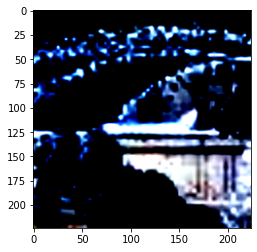

Label: 102, Shape: torch.Size([3, 224, 224])


In [11]:
show_image(train_loader_pretrain)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import sys
sys.path.append('/content/drive/MyDrive/EVA-7-Repo/Models')

In [14]:
import importlib
import resnet
importlib.reload(resnet)
from resnet import ResNet18


In [15]:
import sys
sys.path.append('/content/drive/MyDrive/EVA-7-Repo')


In [16]:
import utils
importlib.reload(utils)
from utils import *

In [17]:
#install_pkg()

In [34]:
import main
importlib.reload(main)
from main import *

In [19]:
epoch = 50
#batch_size = 32
lr = .001*batch_size/64 # Increase LR with batch size

In [25]:
model = ResNet18()
model,optimizer,device,lr_scheduler = initialize_model(p_model = model, p_lr = lr, p_train_mode = 'N')

==> Initializing Model...
==> Model initilaized on  cuda
==> Initializing Optimizer...
==> Adam optimizer initialized
==> LR Scheduler initialized to StepLR to find the max LR with min Loss
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
        BasicBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224

In [21]:
#pause

In [26]:
epoch = 1
l1,l2,l3,l4,l5 =[],[],[],[],[]
#torch.autograd.set_detect_anomaly(True)
l1,l2,l3,l4,l5 = run_train_test_epochs(p_epochs = 1,p_batch_size = batch_size,p_model = model,p_optimizer= optimizer
                                       ,p_device=device,p_train_mode = 'N',p_lr_scheduler = lr_scheduler
                                       ,p_train_loader = train_loader_pretrain, p_test_loader = val_loader_pretrain)


==> Train loop for Epoch #: 1


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Loss=3713.745849609375 Batch_id=164 Accuracy=0.59:   5%|▌         | 165/3125 [01:42<30:45,  1.60it/s]


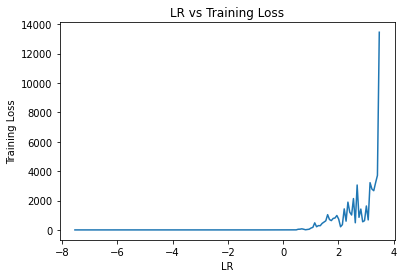

In [27]:
display_graphs(l1,l2,l3,l4,l5)
#print(l2[0])

In [ ]:
pause

In [35]:
# Creating fresh model for training with OCP LRs
model = ResNet18()
model,optimizer,device,lr_scheduler = initialize_model(p_model = model,  p_train_mode = 'Y'
                                                ,p_train_loss_lst = l1,p_lr_lst = l5,p_lr = lr
                                                )

==> Initializing Model...
==> Model initilaized on  cuda
==> Initializing Optimizer...
==> Adam optimizer initialized
==> Max LR dervied for Min Loss =  [0.002030026997733007]
==> OCP Scheduler initialized with Max LR - [0.002030026997733007]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
        BasicBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]     

In [ ]:
pause

In [36]:
epoch = 11
new_l1,new_l2,new_l3,new_l4,new_l5 = run_train_test_epochs(p_epochs = epoch,p_batch_size = batch_size,p_model = model,p_optimizer= optimizer
                                       ,p_device=device,p_train_mode = 'Y',p_lr_scheduler = lr_scheduler
                                       ,p_train_loader = train_loader_pretrain, p_test_loader = val_loader_pretrain)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



==> Setting One cycle policy LR rate for optimizer. LR set to  [0.000568407559365242]

==> Train loop for Epoch #: 1


Loss=4.123875141143799 Batch_id=3124 Accuracy=5.80: 100%|██████████| 3125/3125 [32:11<00:00,  1.62it/s]


==> Test loop for Epoch #: 0
Test set: Average loss: 0.0004, Accuracy: 1030/10000 (10.30%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0015428205182770852]

==> Train loop for Epoch #: 2


Loss=3.6320292949676514 Batch_id=3124 Accuracy=13.03: 100%|██████████| 3125/3125 [32:10<00:00,  1.62it/s]


==> Test loop for Epoch #: 1
Test set: Average loss: 0.0004, Accuracy: 1838/10000 (18.38%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.002030026997733007]

==> Train loop for Epoch #: 3


Loss=3.360931158065796 Batch_id=3124 Accuracy=21.38: 100%|██████████| 3125/3125 [32:15<00:00,  1.61it/s]


==> Test loop for Epoch #: 2
Test set: Average loss: 0.0004, Accuracy: 2489/10000 (24.89%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0019295094639176743]

==> Train loop for Epoch #: 4


Loss=2.4740467071533203 Batch_id=3124 Accuracy=29.90: 100%|██████████| 3125/3125 [32:16<00:00,  1.61it/s]


==> Test loop for Epoch #: 3
Test set: Average loss: 0.0003, Accuracy: 3231/10000 (32.31%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0016478655928104542]

==> Train loop for Epoch #: 5


Loss=3.2689220905303955 Batch_id=3124 Accuracy=36.84: 100%|██████████| 3125/3125 [32:15<00:00,  1.61it/s]


==> Test loop for Epoch #: 4
Test set: Average loss: 0.0003, Accuracy: 3760/10000 (37.60%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0012408784072195328]

==> Train loop for Epoch #: 6


Loss=2.512974739074707 Batch_id=3124 Accuracy=42.84: 100%|██████████| 3125/3125 [32:17<00:00,  1.61it/s]


==> Test loop for Epoch #: 5
Test set: Average loss: 0.0003, Accuracy: 4254/10000 (42.54%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0007891567106214653]

==> Train loop for Epoch #: 7


Loss=2.026900053024292 Batch_id=3124 Accuracy=48.11: 100%|██████████| 3125/3125 [32:20<00:00,  1.61it/s]


==> Test loop for Epoch #: 6
Test set: Average loss: 0.0003, Accuracy: 4506/10000 (45.06%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.0003821695250305441]

==> Train loop for Epoch #: 8


Loss=2.271230697631836 Batch_id=3124 Accuracy=52.92: 100%|██████████| 3125/3125 [32:17<00:00,  1.61it/s]


==> Test loop for Epoch #: 7
Test set: Average loss: 0.0003, Accuracy: 4747/10000 (47.47%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.00010052565392332394]

==> Train loop for Epoch #: 9


Loss=1.7437864542007446 Batch_id=3124 Accuracy=56.37: 100%|██████████| 3125/3125 [32:17<00:00,  1.61it/s]


==> Test loop for Epoch #: 8
Test set: Average loss: 0.0002, Accuracy: 4883/10000 (48.83%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [8.120107990932028e-09]

==> Train loop for Epoch #: 10


Loss=1.4687201976776123 Batch_id=3124 Accuracy=57.25: 100%|██████████| 3125/3125 [32:18<00:00,  1.61it/s]


==> Test loop for Epoch #: 9
Test set: Average loss: 0.0003, Accuracy: 4843/10000 (48.43%)


==> Setting One cycle policy LR rate for optimizer. LR set to  [0.00010052565392332383]

==> Train loop for Epoch #: 11


Loss=2.1893959045410156 Batch_id=3124 Accuracy=56.98: 100%|██████████| 3125/3125 [32:22<00:00,  1.61it/s]


==> Test loop for Epoch #: 10
Test set: Average loss: 0.0002, Accuracy: 4922/10000 (49.22%)



Loss and Accuracy graphs


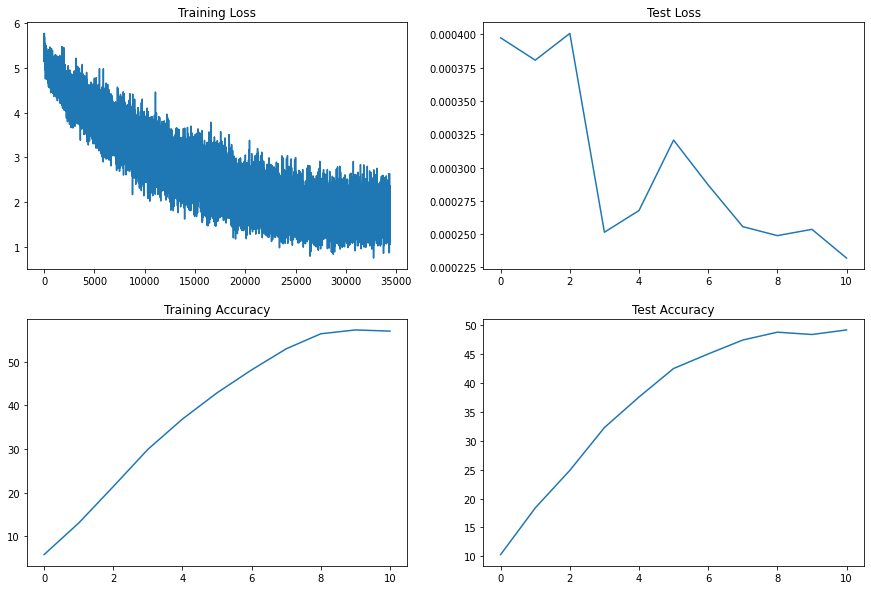

LR Batch Test


In [37]:
display_graphs(new_l1,new_l2,new_l3,new_l4,new_l5)

In [ ]:
Stop